## Time to get your hands dirty! Supernova distances and redshifts (part 2 - 3)

### Part 2 (start in class)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- But check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. To start with, feel free to tweak the hyperparameters manually. But, of course, a publication-quality result will require a cross-validation analysis.

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.
- Think about the pdf of these data in $z$.
- Using your GPR fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given. 

### Part 3 (for the exam)

*(I know this assignment is longer and more convoluted, but we're getting towards the end of the class and it's important to draw connections between the different things we've done)*

We now have a suite of **data-driven** predictive models for our supernova dataset (from polynomials to GPR). That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM. We can do a **parametric** fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). The answer is:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$

- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. Fit it to the data, however you want to do it, using tecniques we've seen throughout the course. Some ideas:
    - Set up a Bayesian framework and use MCMC. 
    - Set up a fully-connected neural network (see end of the class).

- What are the measured value of $H_0$ and $\Omega_m$. What's they errors? Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)


---



# Supernovae data analysis pt.2

## Data Loading

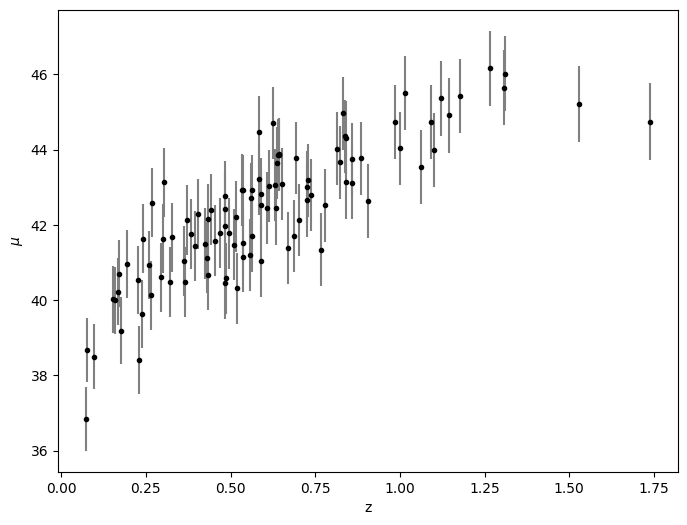

In [1]:
from astroML.datasets import generate_mu_z
import matplotlib.pyplot as plt

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.figure(figsize=(8, 6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.show()

## Gaussian Process Regression
We want to use a Gaussian Process Regression (GPR) to fit the data. A GPR is a non-parametric model that can be used to fit data without assuming a specific functional form.
We can explain the basic idea behind GPR through the following steps:
1. **Prior Distribution**: We start by defining a prior distribution over functions. This is done by specifying a mean function (often assumed to be zero) and a covariance function (also known as a kernel). The choice of the kernel determines the properties of the functions we expect to see (e.g., smoothness, periodicity).
2. **Training Data**: We have a set of training data points, which consist of input-output pairs. The inputs are the independent variables, and the outputs are the dependent variables we want to predict. We add constraints to the model using this data, we consider only the functions that pass through these points.
3. **Posterior Distribution**: Using Bayes' theorem, we update our prior distribution with the training data to obtain the posterior distribution over functions. This posterior distribution reflects our updated beliefs about the functions that could explain the data. 
4. **Prediction**: To make predictions at new input points, we can use the posterior distribution to compute the mean and variance of the predicted outputs. The mean gives us the best estimate of the output, while the variance provides a measure of uncertainty in our predictions.

The operation to find the value of the mean and the variance of the prediction is a sort of mean of all the possible functions that pass through the training points, weighted by their likelihood given the data.

We can use the **GP Assumption**, that states that $\vec{y}$ and $\vec{f^*}$ are distributed according to a multivariate Gaussian distribution with mean zero and covariance matrix $K$:

$$  
p(\vec{y}, \vec{f^*}) = \mathcal{N}(\vec{0}, K) 
\hspace{1cm}K = \begin{pmatrix}
    \hat{K}_{XX} & K_{XX^*} \\
    K_{X^*X}^T & K_{X^*X^*}
  \end{pmatrix},
$$

where 
- $\hat{K}_{XX} = K_{XX} + \text{diag}(\sigma_i^2)$ is the covariance between the input points $x_i$ with observational errors $\sigma_i^2$ added in quadrature to the diagonal.
- $K_{XX^*}$ is the cross-covariance between the input points $x_i$ and the unknown points $x^*_j$.
- $K_{X^*X^*}$ is the covariance between the unknown points $x_j^*$.  

For observed vectors $X$ and $\vec{y}$, and a vector of unknown points $X^*$, it can be shown that the posterior is given by (see the Rasmussen & Williams text above for a detailed proof)

$$  p(f^*_j | \{x_i, y_i, \sigma_i\}, x_j^\ast) = \mathcal{N}(\vec{\mu}, \Sigma) $$

where

$$
\vec{\mu} = K_{XX^*} \hat{K}_{XX}^{-1} \vec{y}, \hspace{1cm}
  \Sigma = K_{X^*X^*} - K_{X^*X}\hat{K}_{XX}^{-1}K_{XX^*}
$$


<div style="text-align: center;">
    <img src="GPR.png" alt="GPR" width="650" height="650">
</div>

/mnt/c/Users/User/Desktop/info/myenv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/c/Users/User/Desktop/info/myenv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/mnt/c/Users/User/Desktop/info/myenv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


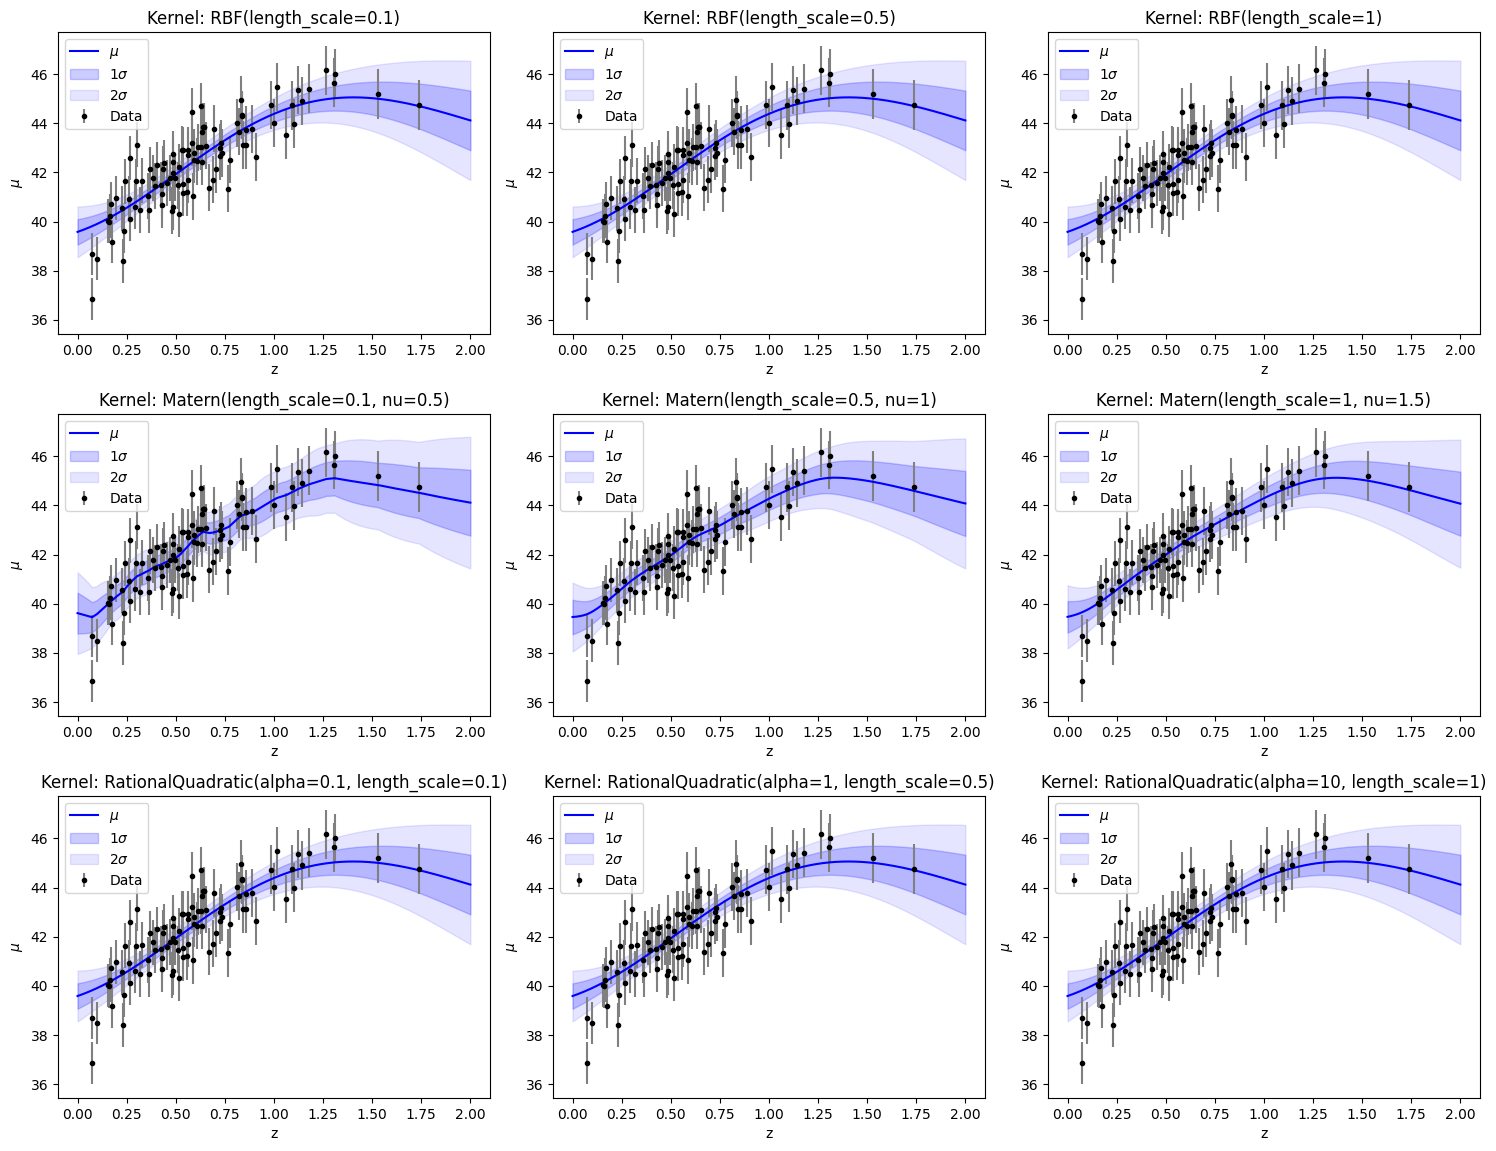

In [2]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

prop_kernels = [
    kernels.RBF(length_scale=0.1),
    kernels.RBF(length_scale=0.5),
    kernels.RBF(length_scale=1.0),
    kernels.Matern(length_scale=0.1, nu=0.5),
    kernels.Matern(length_scale=0.5, nu=1.0),
    kernels.Matern(length_scale=1.0, nu=1.5),
    kernels.RationalQuadratic(length_scale=0.1, alpha=0.1),
    kernels.RationalQuadratic(length_scale=0.5, alpha=1.0),
    kernels.RationalQuadratic(length_scale=1.0, alpha=10.0),
    ]

plt.figure(figsize=(15, 15))

for i, kernel in enumerate(prop_kernels):
    gp = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, normalize_y=True)
    gp.fit(z_sample[:, None], mu_sample)

    z_fit = np.linspace(0, 2, 1000)
    mu_fit, dmu_fit = gp.predict(z_fit[:, None], return_std=True)

    plt.subplot(4, 3, i + 1)
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', label='Data')
    plt.plot(z_fit, mu_fit, '-', label=r'$\mu$', color='b')
    plt.fill_between(z_fit, mu_fit - dmu_fit, mu_fit + dmu_fit, color='b', alpha=0.2, label=r'$1\sigma$')
    plt.fill_between(z_fit, mu_fit - 2*dmu_fit, mu_fit + 2*dmu_fit, color='b', alpha=0.1, label=r'$2\sigma$')
    plt.title(f'Kernel: {kernel}')
    plt.xlabel('z')
    plt.ylabel(r'$\mu$')
    plt.legend()

plt.tight_layout()
plt.show()


We can see how changing the kernel and the parameter values of the kernel, the results doen't change significantly.
So we decide to chose a **RBF kernel**, that is defined as:
$$ 
k(x_i, x_j) = \exp\left(-\frac{(x_i - x_j)^2}{2l^2}\right)
$$
where $l$ is the length scale, that determines how quickly the correlation between points decreases with distance. A small value of $l$ means that points need to be very close to be correlated, while a large value of $l$ means that points can be farther apart and still be correlated.

We also add a **white noise kernel** to account for the observational errors:
$$
k(x_i, x_j) = \sigma_n^2 \delta_{ij}
$$
where $\sigma_n^2$ is the noise level and $\delta_{ij}$ is the Kronecker delta.

/mnt/c/Users/User/Desktop/info/myenv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


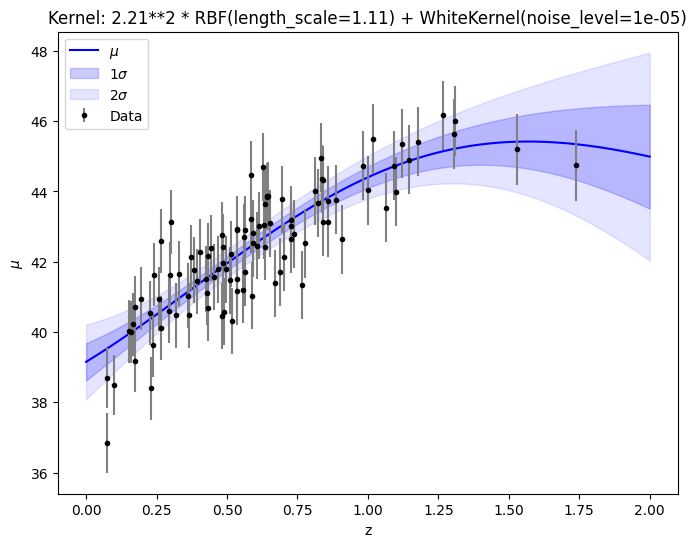

In [3]:
kernel = kernels.ConstantKernel(constant_value_bounds=(1e-3, 1e3)) * kernels.RBF(length_scale=0.3) + kernels.WhiteKernel(noise_level=0.1)

gpr = GaussianProcessRegressor(kernel=kernel, alpha=dmu**2, normalize_y=True)
gpr.fit(z_sample[:, None], mu_sample)
z_fit = np.linspace(0, 2, 1000)
mu_fit, dmu_fit = gpr.predict(z_fit[:, None], return_std=True)

plt.figure(figsize=(8, 6))
plt.plot(z_fit, mu_fit, '-', label=r'$\mu$', color='b')
plt.fill_between(z_fit, mu_fit - dmu_fit, mu_fit + dmu_fit, color='b', alpha=0.2, label=r'$1\sigma$')
plt.fill_between(z_fit, mu_fit - 2*dmu_fit, mu_fit + 2*dmu_fit, color='b', alpha=0.1, label=r'$2\sigma$')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', label='Data')
plt.title(f'Kernel: {gpr.kernel_}')
plt.xlabel('z')
plt.ylabel(r'$\mu$')
plt.legend()    
plt.show()

## Random samples from the posterior
To sample the posterior we use a gaussian KDE.

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

def cross_validation_kde(train_set, bandwidths, cv=5):
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=cv)
    grid.fit(train_set[:, np.newaxis])
    print("Best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

    return grid.best_estimator_.bandwidth

bandwidths = np.linspace(0.01,1.0, 20)

best_bandwidth = cross_validation_kde(z_sample, bandwidths)
print("Optimal bandwidth: ", best_bandwidth)

Best bandwidth: 0.11421052631578947
Optimal bandwidth:  0.11421052631578947


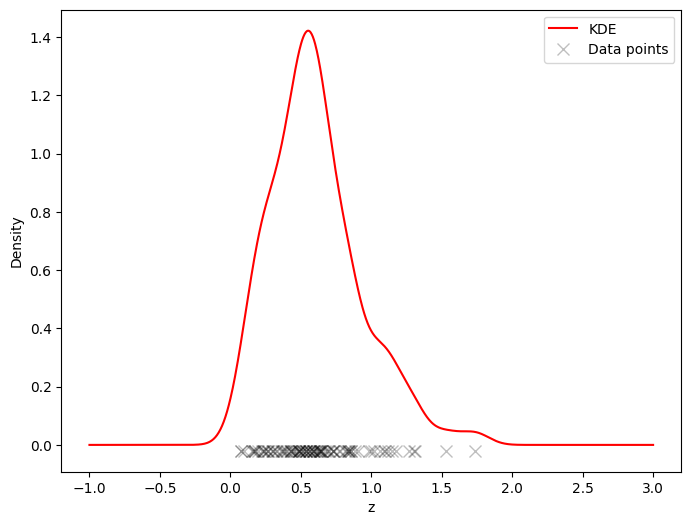

In [5]:
new_z_fit = np.linspace(-1, 3, 1000)

kde = KernelDensity(kernel='gaussian', bandwidth=0.1)
kde.fit(z_sample[:, np.newaxis])
log_density = kde.score_samples(new_z_fit[:, np.newaxis])

pdf = np.exp(log_density)

plt.figure(figsize=(8, 6))
plt.plot(new_z_fit, pdf, label='KDE', color='red')
plt.plot(z_sample, np.zeros_like(z_sample) - 0.02, 'x', color='black', alpha=0.25, label='Data points', markersize=8)
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()
plt.show()

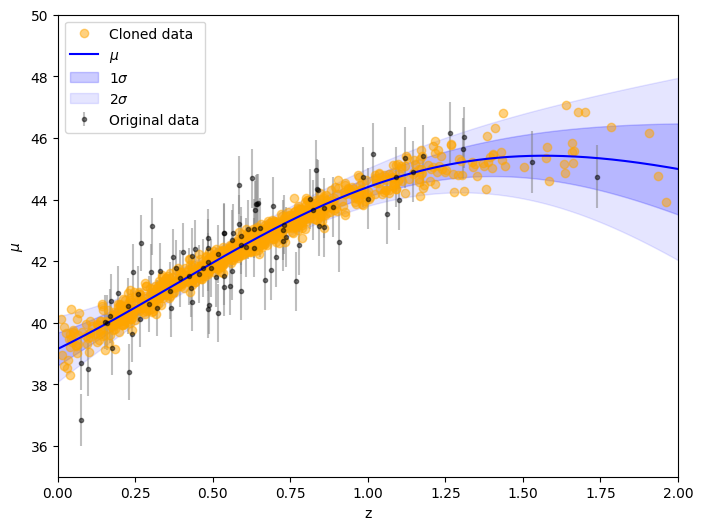

In [ ]:
N = 1000
new_z_samples = kde.sample(N) # Samples N values of z from the KDE

new_mu_samples, new_dmu = gpr.predict(new_z_samples, return_std=True)
mu_gpr = np.random.normal(loc=new_mu_samples, scale=new_dmu)

plt.figure(figsize=(8, 6))    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', label='Original data', alpha=0.5)
plt.plot(new_z_samples, mu_gpr, 'o', color='orange', alpha=0.5, label='Cloned data')
plt.plot(z_fit, mu_fit, '-', label=r'$\mu$', color='b')
plt.fill_between(z_fit, mu_fit - dmu_fit, mu_fit + dmu_fit, color='b', alpha=0.2, label=r'$1\sigma$')
plt.fill_between(z_fit, mu_fit - 2*dmu_fit, mu_fit + 2*dmu_fit, color='b', alpha=0.1, label=r'$2\sigma$')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.show()

# Supernovae data analysis pt.3

## Data Loading

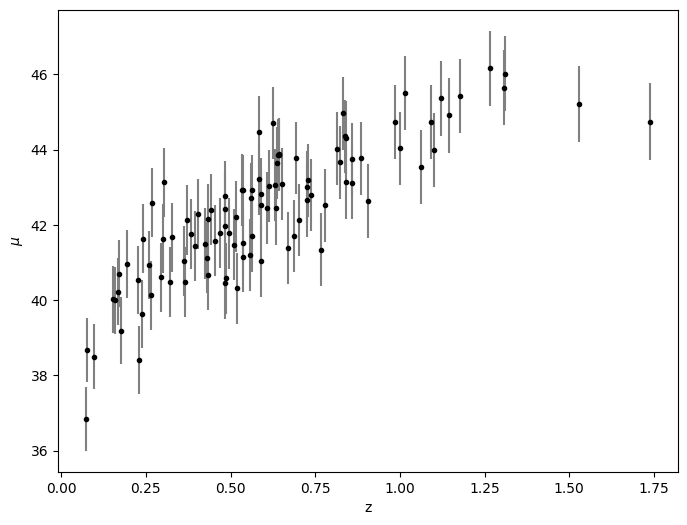

In [7]:
from astroML.datasets import generate_mu_z
import matplotlib.pyplot as plt

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.figure(figsize=(8, 6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.show()

We want to fit the supernovae data with a cosmological model. The model we use is the standard $\Lambda$CDM model, that is defined by the following parameters:
- $H_0$: Hubble constant
- $\Omega_m$: matter density parameter
The model predicts the distance modulus $\mu$ as a function of redshift $z$:
$$
\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right)
$$


In [8]:
from astropy.cosmology import LambdaCDM

def model(redshift, Hubble_const, Omega_matter):
    cosmology = LambdaCDM(H0=Hubble_const, Om0=Omega_matter, Ode0=1 - Omega_matter) # The cosmological model
    dist_modulus = cosmology.distmod(redshift) # Calculate the distance modulus at the specified redshift
    return dist_modulus.value

def log_likelihood(theta, z, mu, mu_err):
    H0, Om0 = theta
    model_mu = model(z, H0, Om0)

    chi2 = np.sum((mu - model_mu) ** 2 / mu_err**2)
    log_normalization = -0.5 * np.sum(np.log(2 * np.pi * mu_err**2))

    return -0.5 * chi2 + log_normalization

def ptform(u):
    omega_m = 0.1 + 0.9 * u[0] # Transform first parameter from [0,1] to Omega_m in [0.1, 1]
    H0 = 30 + 70 * u[1] # Transform second parameter from [0,1] to H0 in [30, 100]

    return np.array([H0, omega_m])

In [9]:
import dynesty
from dynesty import plotting as dyplot

sampler = dynesty.NestedSampler(log_likelihood, ptform, logl_args=[z_sample, mu_sample, dmu], ndim=2, nlive=500)
sampler.run_nested()
sresults = sampler.results

1611it [00:14, 108.52it/s, +500 | bound: 0 | nc: 1 | ncall: 15040 | eff(%): 14.519 | loglstar:   -inf < -132.814 <    inf | logz: -135.173 +/-  0.044 | dlogz:  0.001 >  0.509]


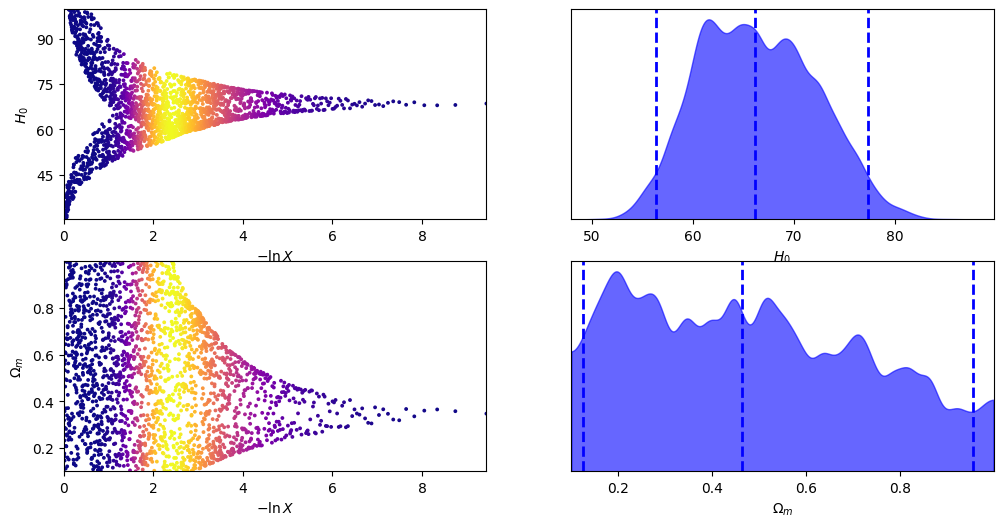

In [10]:
rfig, raxes = dyplot.traceplot(sresults, labels=[r'$H_0$', r'$\Omega_m$'])

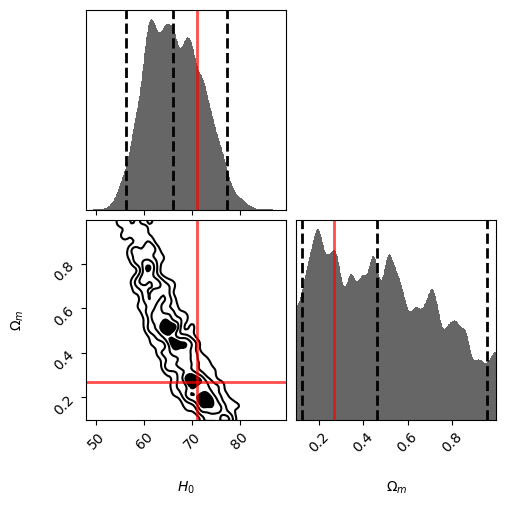

In [11]:
cfig, caxes = dyplot.cornerplot(sresults, labels=[r'$H_0$', r'$\Omega_m$'], truths=[71, 0.27])

In [12]:
from dynesty import utils as dyfunc

mean, cov = dyfunc.mean_and_cov(sresults.samples, np.exp(sresults.logwt - sresults.logz[-1]))
std = np.sqrt(np.diag(cov))

print(cov)
print("H0 = {0:.2f} +/- {1:.2f}".format(mean[0], std[0]))
print("Omega_m = {0:.3f} +/- {1:.3f}".format(mean[1], std[1]))


[[32.14140872 -1.1639762 ]
 [-1.1639762   0.05809908]]
H0 = 66.38 +/- 5.67
Omega_m = 0.486 +/- 0.241


We can try a different approach imposing there isn't Dark Energy, so $\Omega_m = 1$. In this case the model is defined by only one parameter: $H_0$.

In [13]:
def model_nde(redshift, Hubble_const):
    cosmology = LambdaCDM(H0=Hubble_const, Om0=1, Ode0=0) # The cosmological model
    dist_modulus = cosmology.distmod(redshift) # Calculate the distance modulus at the specified redshift
    return dist_modulus.value

def log_likelihood_nde(theta, z, mu, mu_err):
    H0 = theta[0]  # theta è un array, quindi prendiamo il primo elemento
    model_mu = model_nde(z, H0)

    chi2 = np.sum((mu - model_mu) ** 2 / mu_err**2)
    log_normalization = -0.5 * np.sum(np.log(2 * np.pi * mu_err**2))

    return -0.5 * chi2 + log_normalization

def ptform_nde(u):
    H0 = 30 + 70 * u[0] 
    return np.array([H0])

In [14]:
sampler_nde = dynesty.NestedSampler(log_likelihood_nde, ptform_nde, logl_args=[z_sample, mu_sample, dmu], ndim=1, nlive=500)
sampler_nde.run_nested()
sresults_nde = sampler_nde.results

1654it [00:13, 118.96it/s, +500 | bound: 0 | nc: 1 | ncall: 14345 | eff(%): 15.558 | loglstar:   -inf < -133.530 <    inf | logz: -135.932 +/-  0.041 | dlogz:  0.001 >  0.509]


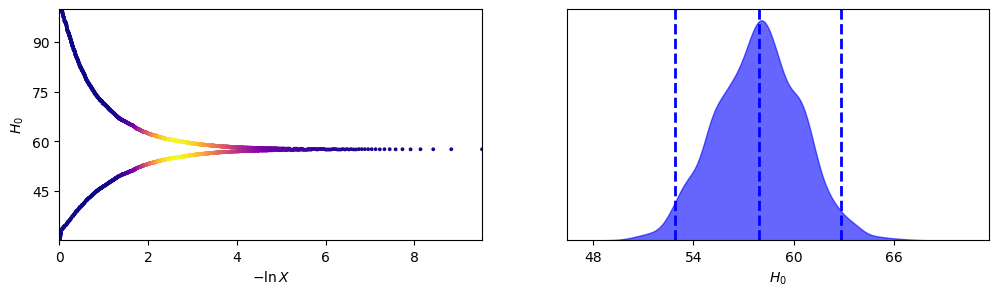

In [15]:
rfig, raxes = dyplot.traceplot(sresults_nde, labels=[r'$H_0$'])

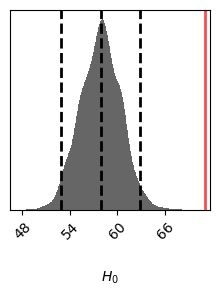

In [16]:
cfig, caxes = dyplot.cornerplot(sresults_nde, labels=[r'$H_0$'], truths=[71])

In [17]:
mean, cov = dyfunc.mean_and_cov(sresults_nde.samples, np.exp(sresults_nde.logwt - sresults_nde.logz[-1]))
std = np.sqrt(np.diag(cov))

print("H0 = {0:.2f} +/- {1:.2f}".format(mean[0], std[0]))

H0 = 57.87 +/- 2.53


Using the Bayes factor we can compare the two models and see which one is preferred by the data. The Bayes factor is defined as the ratio of the evidences of the two models:

In [18]:
Z = np.exp(sampler.results.logz[-1])
Z_nde = np.exp(sampler_nde.results.logz[-1])

B = Z / Z_nde
print("Bayes factor: ", B)

Bayes factor:  2.1354913153700323
